**Ensembling 5 Models (Hard Voting and Soft Voting) with Oversampling: Logistic Regression, SVM, Decision Tree, Random Forest, and MLP Classifier**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Random seed for reproducibility
np.random.seed(17)

In [2]:
# ===================== LOAD AND CLEAN DATA =====================
data_ksi = pd.read_csv("./Total_KSI.csv")

# Initial data overview
"""Displays an overview of the dataset."""
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

print("\n===================== DATA OVERVIEW =====================")
print("\nFirst 3 Records:\n", data_ksi.head(3))
print("\nShape of the DataFrame:", data_ksi.shape)
print("\nData Types:\n", data_ksi.dtypes)

print("\n===================== DATA DESCRIPTION =====================")
print("\nStatistical Summary:\n", data_ksi.describe())

print("\n===================== COLUMN INFORMATION =====================")
data_ksi.info()

print("\n===================== MISSING VALUES =====================")
missing_data = data_ksi.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(data_ksi)) * 100
print(pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent Missing']))

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())

print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column} ({len(data_ksi[column].unique())}):", data_ksi[column].unique())

# Drop unnecessary columns -  ACCNUM, DATE , TIME,            
columns_to_drop= [
    "OBJECTID","INDEX", "FATAL_NO", "x", "y", "OFFSET", "STREET1", "STREET2",
    "NEIGHBOURHOOD_140", "HOOD_140", "HOOD_158", "CYCLISTYPE", "CYCACT","INITDIR",
    "VEHTYPE", "MANOEUVER", "DRIVACT", "DRIVCOND", "PEDTYPE", "PEDACT",
    "INJURY", "DIVISION"]



===================== DATA OVERVIEW =====================

First 3 Records:
    OBJECTID    INDEX    ACCNUM                  DATE  TIME       STREET1  \
0         1  3389067  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
1         2  3389068  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
2         3  3389069  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   

       STREET2 OFFSET      ROAD_CLASS               DISTRICT   LATITUDE  \
0  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
1  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
2  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   

   LONGITUDE                ACCLOC    TRAFFCTL VISIBILITY LIGHT RDSFCOND  \
0 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
1 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
2 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   

           

In [3]:
# Drop unnecessary columns
data_ksi.drop(columns=columns_to_drop, inplace=True)

# Handle missing target values and specific rows
data_ksi['ACCLASS'] = data_ksi['ACCLASS'].fillna('Fatal')
data_ksi.drop(data_ksi[data_ksi['ACCLASS'] == 'Property Damage O'].index, inplace=True)
data_ksi.drop_duplicates(inplace=True)

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


Class Distribution:
 ACCLASS
Non-Fatal Injury    15356
Fatal                2514
Name: count, dtype: int64


In [4]:
import pandas as pd

def aggregate_rows(group):
    # Find the row with the maximum number of non-null values in the group
    max_non_null_row_idx = group.notnull().sum(axis=1).idxmax()
    max_non_null_row = group.loc[max_non_null_row_idx].copy()

    # Create a DataFrame to store rows that were excluded from aggregation (excluding the max row)
    excluded_rows = group.drop(max_non_null_row_idx)

    # Apply aggregation based on the column type (mean for numerical, mode for categorical)
    for col in max_non_null_row.index:
        if pd.api.types.is_numeric_dtype(group[col]):
            # For numerical columns, apply the mean
            mean_value = group[col].mean()
            max_non_null_row[col] = mean_value
        else:
            # For categorical columns, apply the mode
            mode_value = group[col].mode().iloc[0] if not group[col].mode().empty else None
            max_non_null_row[col] = mode_value

    # # Append excluded rows to the CSV file (if file exists, append; if not, create new file)
    # excluded_rows.to_csv('./excluded_rows_v1.csv', mode='a', header=not pd.io.common.file_exists('./excluded_rows_v1.csv'), index=False)

    # Return the processed non-Fatal row (max row)
    return max_non_null_row.to_frame().T


In [5]:
# Separate fatal rows
fatal_rows = data_ksi[data_ksi['ACCLASS'] == 'Fatal']

# Separate non-fatal rows
non_fatal_rows = data_ksi[data_ksi['ACCLASS'] != 'Fatal']

# Apply aggregation logic on non-fatal rows based on ACCNUM
aggregated_data = non_fatal_rows.groupby(['ACCNUM'], as_index=False).apply(aggregate_rows, include_groups=False).reset_index(drop=True)

# Combine the aggregated data with the fatal rows
data_ksi = pd.concat([aggregated_data, fatal_rows], ignore_index=True)

# Shuffle the combined data
data_ksi = data_ksi.sample(frac=1, random_state=42).reset_index(drop=True)

data_ksi.drop(columns=['ACCNUM'], inplace=True)

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())

Class Distribution:
 ACCLASS
Non-Fatal Injury    4324
Fatal               2514
Name: count, dtype: int64


In [6]:
# Map month numbers to seasons using the MONTH column
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

In [7]:
def data_cleaning(data_ksi):
    data_ksi = data_ksi.copy()
    # Format date and time
    data_ksi["DATE"] = pd.to_datetime(data_ksi["DATE"]).dt.to_period("D").astype(str)
    
    # Extract date components from the 'DATE' column
    data_ksi['MONTH'] = pd.to_datetime(data_ksi['DATE']).dt.month
    
    # Extract season
    data_ksi['SEASON'] = data_ksi['MONTH'].apply(month_to_season).astype(float)
    
    # Replace specific values
    data_ksi['ROAD_CLASS'] = data_ksi['ROAD_CLASS'].str.replace(r'MAJOR ARTERIAL ', 'MAJOR ARTERIAL', regex=False)
    
    unknown_columns = ['PEDCOND','CYCCOND','DISTRICT']
    other_columns = ['ROAD_CLASS', 'ACCLOC', 'VISIBILITY', 'LIGHT', 'RDSFCOND','INVAGE','TRAFFCTL','INVTYPE', 'IMPACTYPE',]
    boolean_columns = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH',
                       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY','EMERG_VEH']
    
    data_ksi[boolean_columns] = data_ksi[boolean_columns].fillna("No")
    
    data_ksi['INVAGE'] = data_ksi['INVAGE'].fillna("unknown")
    
    # Handle age column
    data_ksi['INVAGE'] = data_ksi['INVAGE'].replace('unknown', np.nan)
    data_ksi['INVAGE'] = data_ksi['INVAGE'].str.replace('OVER 95', '95 to 100')
    data_ksi[['min_age', 'max_age']] = data_ksi['INVAGE'].str.split(' to ', expand=True)
    data_ksi['min_age'] = pd.to_numeric(data_ksi['min_age'], errors='coerce')
    data_ksi['max_age'] = pd.to_numeric(data_ksi['max_age'], errors='coerce')
    data_ksi['AVG_AGE'] = data_ksi[['min_age', 'max_age']].mean(axis=1).astype(float)
    
    data_ksi.drop(columns=['INVAGE','min_age', 'max_age'], inplace=True)

    data_ksi['INVAGE'] = data_ksi['AVG_AGE'].fillna(data_ksi['AVG_AGE'].mean()).astype(float)

    data_ksi[other_columns] = data_ksi[other_columns].fillna("Other")
    data_ksi[unknown_columns] = data_ksi[unknown_columns].fillna("Unknown")
    
    # Convert boolean columns to numeric
    pd.set_option('future.no_silent_downcasting', True)
    data_ksi[boolean_columns] = data_ksi[boolean_columns].replace({'Yes': 1, 'No': 0}).astype(float)
    
    data_ksi["TRAFFCTL"] = data_ksi["TRAFFCTL"].fillna("No_Control")

    # Convert LATITUDE and LONGITUDE to float
    data_ksi[['LATITUDE', 'LONGITUDE']] = data_ksi[['LATITUDE', 'LONGITUDE']].astype(float)

    data_ksi['HOUR'] = data_ksi['TIME'].apply(lambda x: f"{int(x) // 100:02d}" if x >= 100 else '00')  # Extract hours for 3 or 4 digits
    data_ksi['MINUTE'] = data_ksi['TIME'].apply(lambda x: f"{int(x) % 100:02d}" if x >= 100 else f"{int(x):02d}")  # Extract minutes
    
    data_ksi['HOUR'] = data_ksi['HOUR'].astype(int)
    data_ksi['MINUTE'] = data_ksi['MINUTE'].astype(int)
    
    data_ksi.drop(columns=['AVG_AGE','TIME','DATE'], inplace=True)

    return data_ksi

In [8]:
data_ksi = data_cleaning(data_ksi)

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=17)
X_res, y_res = ros.fit_resample(data_ksi.drop(columns=['ACCLASS']), data_ksi['ACCLASS'])
data_ksi = pd.concat([X_res, y_res], axis=1).sample(frac=1, random_state=17).reset_index(drop=True)

print("\n===================== DATA CLEANING DONE =====================")
print("\nShape of the DataFrame after cleaning:", data_ksi.shape)
print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


===================== DATA CLEANING DONE =====================

Shape of the DataFrame after cleaning: (8648, 33)
Class Distribution:
 ACCLASS
Fatal               4324
Non-Fatal Injury    4324
Name: count, dtype: int64


In [10]:
print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column}:", data_ksi[column].unique())


===================== UNIQUE VALUES =====================

Unique values in ROAD_CLASS: ['Major Arterial' 'Minor Arterial' 'Collector' 'Other' 'Expressway'
 'Local' 'Major Arterial ' 'Expressway Ramp' 'Laneway' 'Major Shoreline'
 'Pending']

Unique values in DISTRICT: ['Etobicoke York' 'North York' 'Toronto and East York' 'Scarborough'
 'Unknown']

Unique values in LATITUDE: [43.685427 43.723689 43.638145 ... 43.748702 43.654292 43.683936]

Unique values in LONGITUDE: [-79.495136 -79.494914 -79.55149  ... -79.454868 -79.406802 -79.356914]

Unique values in ACCLOC: ['Non Intersection' 'Other' 'At Intersection' 'Intersection Related'
 'At/Near Private Drive' 'Underpass or Tunnel' 'Overpass or Bridge'
 'Laneway' 'Private Driveway']

Unique values in TRAFFCTL: ['No Control' 'Stop Sign' 'Traffic Signal' 'Other' 'Police Control'
 'Pedestrian Crossover' 'Traffic Controller' 'Streetcar (Stop for)'
 'School Guard' 'Traffic Gate' 'Yield Sign']

Unique values in VISIBILITY: ['Clear' 'Snow' 'Othe

In [11]:
features = data_ksi.drop(columns=["ACCLASS"])
target = data_ksi["ACCLASS"]

unseen_features = features[-10:]
unseen_labels = target[-10:]

features = features[:-10]
target = target[:-10]

cleaned_df = data_ksi.drop(data_ksi.index[-10:])

# Encode the target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Encode unseen labels
unseen_labels = label_encoder.transform(unseen_labels)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the data into train & test
X_train, X_test, y_train, y_test = train_test_split(
        features, target, stratify=target, test_size=0.2, random_state=17)

# Preprocess the data
num_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = features.select_dtypes(include=['object']).columns.tolist()

print("\n===================== FEATURES INFO =====================")
print("\nNumerical Features:", num_features)
print("\nCategorical Features:", cat_features)

num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='mode')),
        ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

preprocessor = ColumnTransformer([
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
unseen_features = preprocessor.transform(unseen_features)


===================== FEATURES INFO =====================

Numerical Features: ['LATITUDE', 'LONGITUDE', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'SEASON', 'INVAGE']

Categorical Features: ['ROAD_CLASS', 'DISTRICT', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'PEDCOND', 'CYCCOND', 'NEIGHBOURHOOD_158']


In [12]:
def fit_and_predict(classifiers, X_train, y_train, X_test, y_test, voting_type,unseen_features, unseen_labels):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import (
        accuracy_score, f1_score, roc_auc_score, confusion_matrix, 
        precision_score, recall_score, classification_report, roc_curve, auc
    )
    from sklearn.ensemble import VotingClassifier

    fitted_classifiers = []

    print(f"\n===================== {voting_type.upper()} VOTING PREDICTIONS =====================")
    print("\nPredicting for the first three instances of test data:")

    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        fitted_classifiers.append(classifier) 
        
        predictions = classifier.predict(X_test[:3])
        y_pred = classifier.predict(X_test)

        print(f"\nClassifier: {classifier}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))

        print("Training Accuracy Score:", classifier.score(X_train, y_train))
        print("Testing Accuracy Score:", accuracy_score(y_test, y_pred))
        print("Precision Score:", precision_score(y_test, y_pred))
        print("Recall Score:", recall_score(y_test, y_pred))
        print("F1 Score:", f1_score(y_test, y_pred))
        print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

        print(f"Predictions: {predictions}")
        print(f"Actual Values: {y_test[:3]}")

        # Unseen Data Evaluation
        classifier.fit(unseen_features, unseen_labels)
        unseen_predictions = classifier.predict(unseen_features)
        unseen_accuracy = classifier.score(unseen_features, unseen_labels)

        print("\n===================== UNSEEN DATA METRICS =====================")
        print("\nUnseen Predictions:", unseen_predictions)
        for i in range(len(unseen_features)):
            print(f"Predicted: {unseen_predictions[i]} Actual: {unseen_labels[i]}")
        
        print(f"Unseen Data Accuracy: {unseen_accuracy:.4f}")

        # Only plot for VotingClassifier
        if isinstance(classifier, VotingClassifier):
            # Confusion Matrix Plot
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{voting_type.upper()} Voting - Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()

            # Classification Report Heatmap
            report = classification_report(y_test, y_pred, output_dict=True)
            df_report = pd.DataFrame(report).transpose()
            plt.figure(figsize=(8, 5))
            sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
            plt.title(f'{voting_type.upper()} Voting - Classification Report')
            plt.tight_layout()
            plt.show()

            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{voting_type.upper()} Voting - ROC Curve')
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.show()

    return fitted_classifiers


In [13]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Define the classifiers
log_reg_H = LogisticRegression(max_iter=1400)

dt_H = DecisionTreeClassifier(criterion='entropy', max_depth=42)

nn_H = MLPClassifier(
    activation='tanh',
    alpha=0.01,
    hidden_layer_sizes=(15, 10, 1),
    learning_rate='invscaling',
    max_iter=1000,
    solver='adam')

#svm_H = SVC(C=1, kernel='linear')

svm_H = SVC(
    C=0.1,
    kernel='poly',
    degree=3,
    gamma=0.1
)
#svm_soft_H = SVC(C=1, kernel='linear',probability=True)  # For soft voting
svm_soft_H = SVC(
    C=0.1,
    kernel='poly',
    degree=3,
    gamma=0.1,probability=True
)
rf_H = RandomForestClassifier(
    n_estimators=1000, 
    random_state=37, 
    n_jobs=-1, 
    class_weight='balanced')



===================== HARD VOTING PREDICTIONS =====================

Predicting for the first three instances of test data:

Classifier: LogisticRegression(max_iter=1400)
Confusion Matrix:
 [[729 135]
 [118 746]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       864
           1       0.85      0.86      0.86       864

    accuracy                           0.85      1728
   macro avg       0.85      0.85      0.85      1728
weighted avg       0.85      0.85      0.85      1728

Training Accuracy Score: 0.876410998552822
Testing Accuracy Score: 0.8535879629629629
Precision Score: 0.8467650397275823
Recall Score: 0.8634259259259259
F1 Score: 0.8550143266475645
ROC AUC Score: 0.853587962962963
Predictions: [0 0 1]
Actual Values: [0 0 1]

===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [0 1 1 0 0 1 0 1 1 1]
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 1 Actual:

C:\Users\Vivek K\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [0 1 1 0 0 1 0 1 1 1]
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Unseen Data Accuracy: 1.0000

Classifier: VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1400)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=37)),
                             ('svm', SVC(C=0.1, gamma=0.1, kernel='poly')),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                        

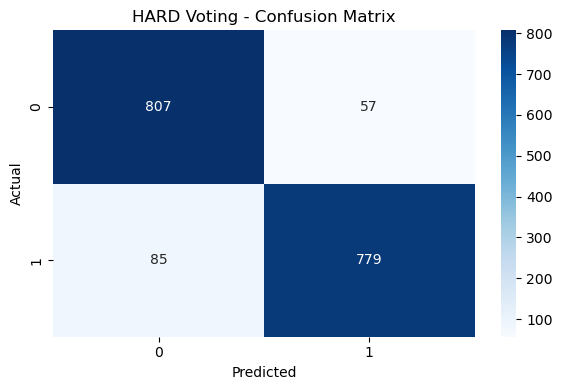

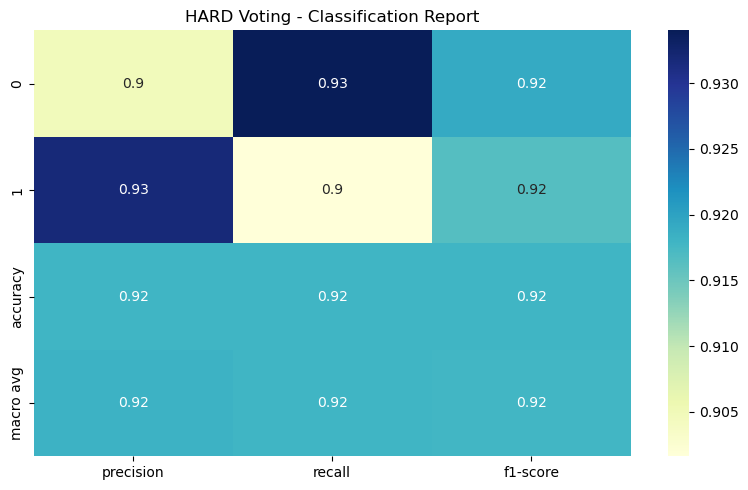

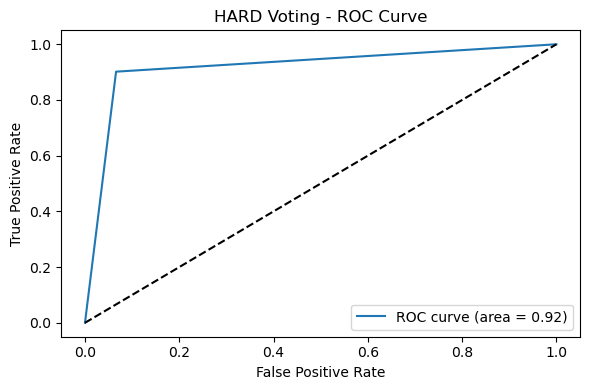

In [14]:
# hard voting
voting_H = VotingClassifier(estimators=[('lr', log_reg_H), ('rf', rf_H), ('svm', svm_H), ('dt', dt_H), ('nn', nn_H)], voting='hard')
classifiers_hard = [log_reg_H, rf_H, svm_H, dt_H, nn_H, voting_H]

trained_classifiers_H = fit_and_predict(classifiers_hard, X_train, y_train, X_test, y_test, "Hard",unseen_features,unseen_labels)


===================== SOFT VOTING PREDICTIONS =====================

Predicting for the first three instances of test data:

Classifier: LogisticRegression(max_iter=1400)
Confusion Matrix:
 [[729 135]
 [118 746]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       864
           1       0.85      0.86      0.86       864

    accuracy                           0.85      1728
   macro avg       0.85      0.85      0.85      1728
weighted avg       0.85      0.85      0.85      1728

Training Accuracy Score: 0.876410998552822
Testing Accuracy Score: 0.8535879629629629
Precision Score: 0.8467650397275823
Recall Score: 0.8634259259259259
F1 Score: 0.8550143266475645
ROC AUC Score: 0.853587962962963
Predictions: [0 0 1]
Actual Values: [0 0 1]

===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [0 1 1 0 0 1 0 1 1 1]
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 1 Actual:

C:\Users\Vivek K\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [0 1 1 0 0 1 0 1 1 1]
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Unseen Data Accuracy: 1.0000


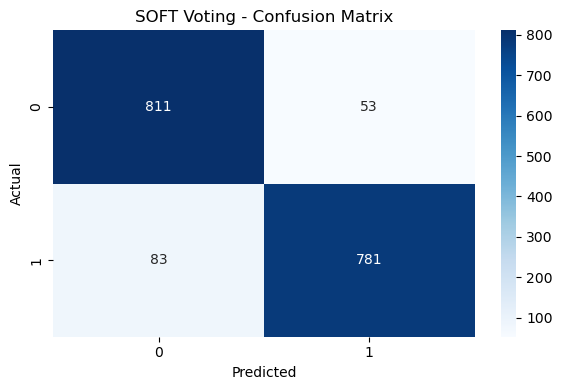

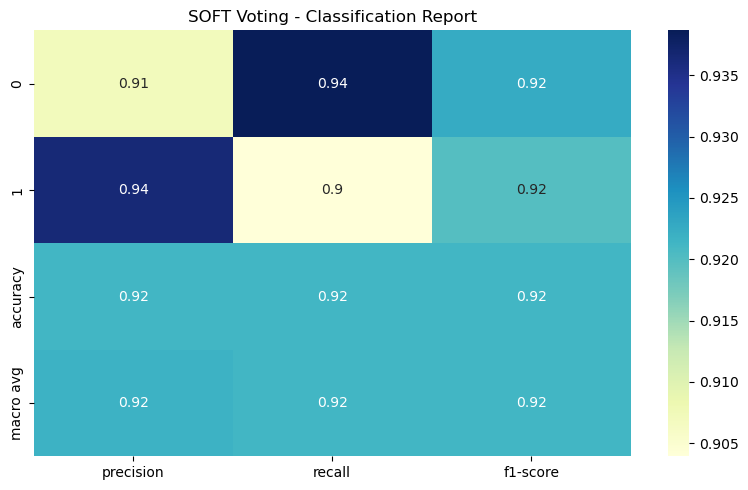

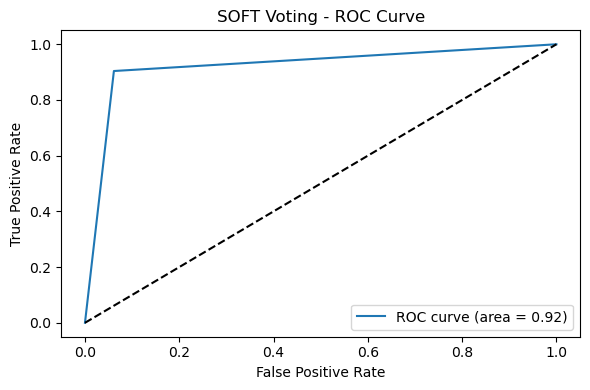

In [15]:
# Soft voting
voting_S = VotingClassifier(estimators=[('lr', log_reg_H), ('rf', rf_H), ('svm', svm_soft_H), ('dt', dt_H), ('nn', nn_H)], voting='soft')
classifiers_soft = [log_reg_H, rf_H, svm_soft_H, dt_H, nn_H, voting_S]

trained_classifiers_S = fit_and_predict(classifiers_soft, X_train, y_train, X_test, y_test, "Soft",unseen_features,unseen_labels)


In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score
from joblib import dump

# Load and preprocess unseen data
unseen_data = pd.read_csv("./excluded_rows_v1.csv")
unseen_df = data_cleaning(unseen_data)

# Split features and target
unseen_features = unseen_df.drop(columns=["ACCLASS"])
unseen_target = unseen_df["ACCLASS"]

# Transform data
unseen_features_transformed = preprocessor.transform(unseen_features)
transformed_unseen_target = label_encoder.transform(unseen_target)

# Model names for labeling
model_names = [
    "Logistic Regression", "RandomForest", "Support Vector Machine",
    "Decision Tree", "MLP Classifier", "Voting Classifier"
]

# Loop through classifiers and evaluate + save
for i in range(6): 
    best_model_H = trained_classifiers_H[i]
    best_model_S = trained_classifiers_S[i]

    # Predict
    predictions_1 = best_model_H.predict(unseen_features_transformed)
    predictions_2 = best_model_S.predict(unseen_features_transformed)

    # Accuracy
    accuracy1 = accuracy_score(transformed_unseen_target, predictions_1)
    accuracy2 = accuracy_score(transformed_unseen_target, predictions_2)

    # Display results
    print(f"{model_names[i]} - Hard Voting: Accuracy on Unseen Data: {accuracy1 * 100:.2f}%")
    print(f"{model_names[i]} - Soft Voting: Accuracy on Unseen Data: {accuracy2 * 100:.2f}%")
    print("=" * 50)

    # Save models with joblib
    dump(best_model_H, f"./pickles/{model_names[i].replace(' ', '_')}_HardVoting.joblib")
    dump(best_model_S, f"./pickles/{model_names[i].replace(' ', '_')}_SoftVoting.joblib")

# Save the preprocessor and label encoder
dump(preprocessor, "./pickles/preprocessor.joblib")
dump(label_encoder, "./pickles/label_encoder.joblib")


Logistic Regression - Hard Voting: Accuracy on Unseen Data: 70.35%
Logistic Regression - Soft Voting: Accuracy on Unseen Data: 70.35%
RandomForest - Hard Voting: Accuracy on Unseen Data: 79.68%
RandomForest - Soft Voting: Accuracy on Unseen Data: 79.68%
Support Vector Machine - Hard Voting: Accuracy on Unseen Data: 96.60%
Support Vector Machine - Soft Voting: Accuracy on Unseen Data: 96.60%
Decision Tree - Hard Voting: Accuracy on Unseen Data: 78.49%
Decision Tree - Soft Voting: Accuracy on Unseen Data: 78.49%
MLP Classifier - Hard Voting: Accuracy on Unseen Data: 59.63%
MLP Classifier - Soft Voting: Accuracy on Unseen Data: 59.63%
Voting Classifier - Hard Voting: Accuracy on Unseen Data: 79.83%
Voting Classifier - Soft Voting: Accuracy on Unseen Data: 70.11%


['./pickles/label_encoder.joblib']